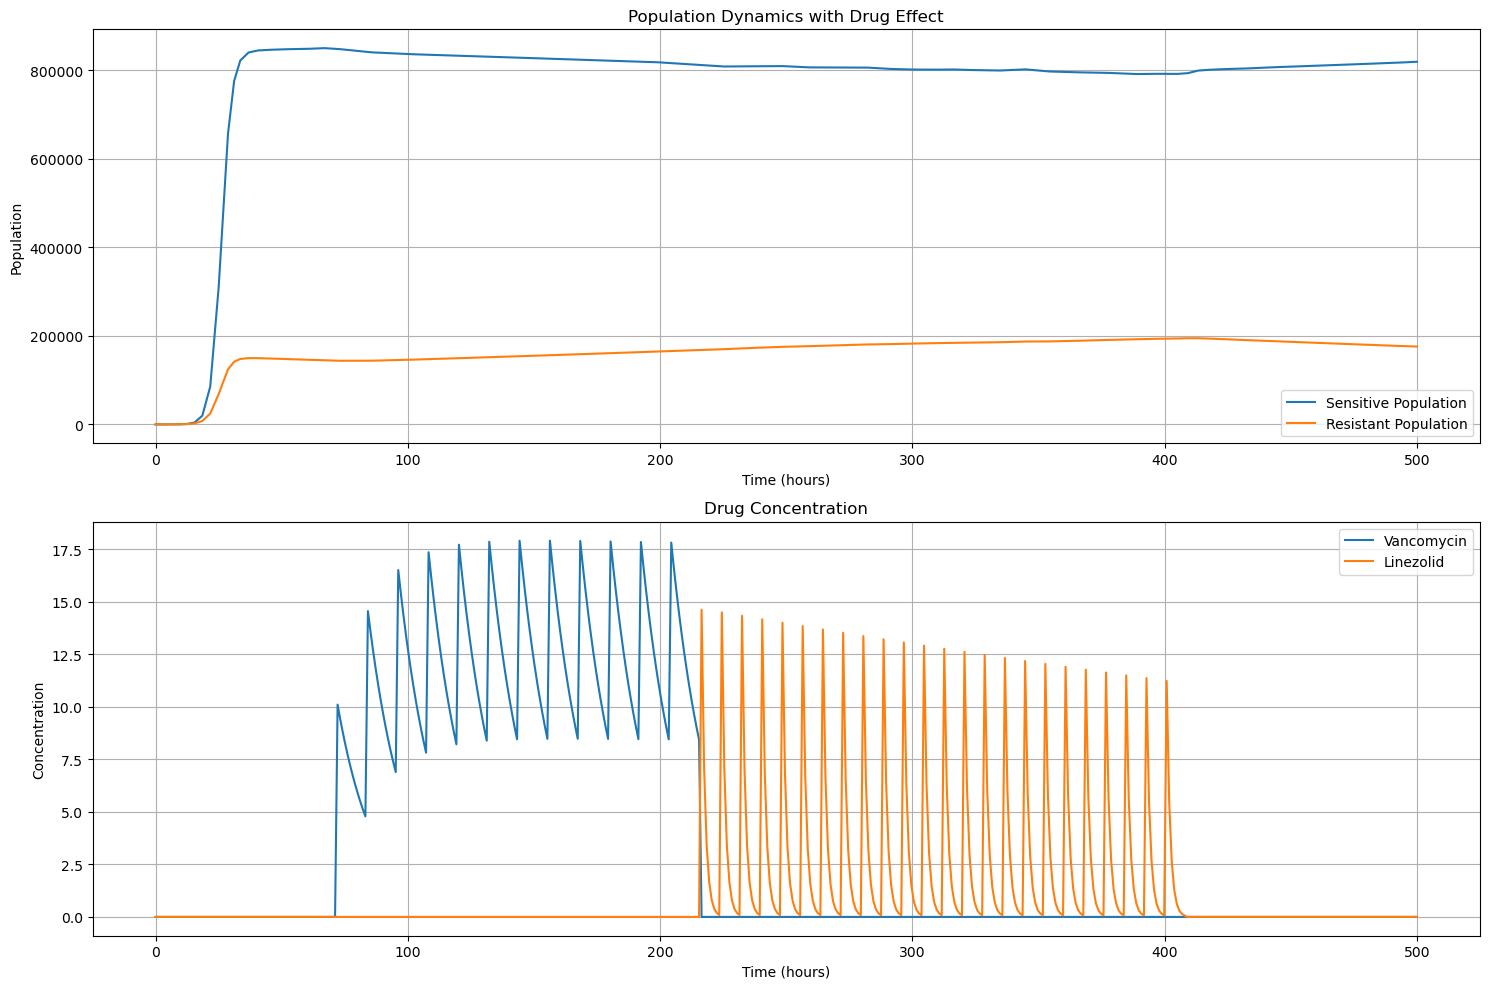

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    conc = np.zeros_like(t)
    if dosing_times is None:
        # If no specific dosing times, create regular dosing schedule
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            # Calculate contribution from each dose
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def simulate_drug_dynamics(
    initial_sensitive=2, 
    initial_resistant=5, 
    total_simulation_time=500,
    no_drug_period=72,
    vancomycin_duration=6*24,
    linezolid_duration=8*24,
):
    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 40

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration

    # Create specific dosing times for Linezolid
    linezolid_dosing_times = np.arange(linez_start, linez_end, tau_linezolid)

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin, 
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, 
        linez_start, linez_end, linezolid_dosing_times
    )

    # Rest of the code remains the same as in previous version
    conc_combined = conc_vancomycin + conc_linezolid

    # Population Dynamics Parameters
    rho_sensitive = 0.5
    rho_resistant = 0.4
    k = 10e5
    EC_50 = 0.03
    max_drug_effect = 0.8
    
    delta_sensitive = 0.002
    delta_resistant = 0.003

    def population_ode(t, r):
        S, R = r
        conc_t = np.interp(t, time, conc_combined)
        
        drug_inhibition = max_drug_effect * (conc_t / (conc_t + EC_50))
        
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - drug_inhibition) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.5 * drug_inhibition) - delta_resistant * R
        
        return [dSdt, dRdt]

    solution = solve_ivp(
        population_ode, 
        [0, total_simulation_time], 
        [initial_sensitive, initial_resistant],
        dense_output=True
    )

    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(solution.t, solution.y[0], label='Sensitive Population')
    plt.plot(solution.t, solution.y[1], label='Resistant Population')
    plt.title('Population Dynamics with Drug Effect')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin')
    plt.plot(time, conc_linezolid, label='Linezolid')
    plt.title('Drug Concentration')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return solution, time, conc_combined

# Run the simulation
solution, time, conc_combined = simulate_drug_dynamics()